In [182]:
#import kagglehub

"""
# Download latest version
path = kagglehub.dataset_download("Path to working directory", "dataset_name") # Esto es para descartar el dataset inicial, poner el path en tu ordenador local

print("Path to dataset files:", path)
"""

'\n# Download latest version\npath = kagglehub.dataset_download("Path to working directory", "dataset_name") # Esto es para descartar el dataset inicial, poner el path en tu ordenador local\n\nprint("Path to dataset files:", path)\n'

In [183]:
import pandas as pd
df = pd.read_csv('amazon_reviews.csv')
df.head() #Aqui podemos ver el dataset usado, varias columnas innecesarias

,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
0,0,NaN,4.0,No issues.,2014-07-23,138,0,0,0,0,0.0,0.0
1,1,0mie,5.0,"Purchased this for my device, it worked as adv...",2013-10-25,409,0,0,0,0,0.0,0.0
2,2,1K3,4.0,it works as expected. I should have sprung for...,2012-12-23,715,0,0,0,0,0.0,0.0
3,3,1m2,5.0,This think has worked out great.Had a diff. br...,2013-11-21,382,0,0,0,0,0.0,0.0
4,4,2&amp;1/2Men,5.0,"Bought it with Retail Packaging, arrived legit...",2013-07-13,513,0,0,0,0,0.0,0.0


In [ ]:
#Limpiar el dataset
dfSimple = df.drop(columns=['reviewerName', 'reviewTime', 'day_diff', 'helpful_yes', 'helpful_no', 'total_vote', 'score_pos_neg_diff', 'score_average_rating', 'wilson_lower_bound'])

#De inicio trabajaremos con un dataset masivamente simplificado para poder hacer pruebas, la columna unnamed:0 no se elimina porque es un identificador de la fila y puede ser util mas adelante
dfSimple.dropna(subset=["reviewText"], inplace=True)
dfSimple.head()


In [185]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

In [186]:
# NLTK resources
nltk.download('stopwords') #Llista de stopwords + comunes
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lianbaguebatlle/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/lianbaguebatlle/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [187]:
# Cleaning function : punctuation, numbers, URL, convert to lowercase, tokenize, remove stopwords.
"""
def clean_text(text):
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    # Remove punctuation and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Tokenize the text
    #words = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in text if word not in stop_words]
    return ' '.join(words)
"""

def clean_text(text):
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    # Remove punctuation and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Split text into words
    words = text.split()
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    # Join words back into a single string
    return ' '.join(words)

In [188]:
# Create a new DataFrame with cleaned reviewText and the overall column
dfCleaned = dfSimple.copy()
dfCleaned['reviewText'] = dfCleaned['reviewText'].apply(clean_text)  # Apply the cleaning function
#dfCleaned['overall'] = dfCleaned['overall']  # Include the overall column

print(dfCleaned.head())

   Unnamed: 0  overall                                         reviewText
0           0      4.0                                             issues
1           1      5.0  purchased device worked advertised never much ...
2           2      4.0  works expected sprung higher capacity think ma...
3           3      5.0  think worked greathad diff bran gb card went s...
4           4      5.0  bought retail packaging arrived legit orange e...


In [189]:
# Save the cleaned dataset 
dfCleaned.to_csv('amazon_reviews_Cleaned.csv', index=False)

print("Cleaned dataset saved as 'amazon_reviews_simpleBinaryCleaned.csv'")

Cleaned dataset saved as 'amazon_reviews_simpleBinaryCleaned.csv'


In [190]:
#Por ahora, trabajaremos con valores de 0 o 1 en la columna overall para tener un problema simple y poder de inicio identifcar de manera binaria si es positiva o negativa la review. Despues, querremos predecir la nota de la review por el texto con mas exactitud
dfSimpleBinary = dfCleaned.copy()
dfSimpleBinary['overall'] = dfSimpleBinary['overall'].apply(lambda x: 1 if x > 2.5 else 0)
dfSimpleBinary['overall'].value_counts()
dfSimpleBinary.head(1000)

,Unnamed: 0,overall,reviewText
0,0,1,issues
1,1,1,purchased device worked advertised never much ...
2,2,1,works expected sprung higher capacity think ma...
3,3,1,think worked greathad diff bran gb card went s...
4,4,1,bought retail packaging arrived legit orange e...
...,...,...,...
996,996,1,bought digital recorder memory card slot card ...
997,997,1,much say memory card works great go pro hero s...
998,998,1,gig microsd card costs less dollar per gig cla...
999,999,1,im nerd hoarder waited year memory gb wanted c...


In [191]:
#Guardamos el dataset limpio para no sobreescribirlo accidentalmente, este paso es solo una precaucion. solo falta borrar los nans
dfSimpleBinary.to_csv('amazon_reviews_simpleBinary.csv', index=False)

In [192]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Apply TF-IDF
tfidf = TfidfVectorizer(max_features=5000)  # Limit to 5000 features for simplicity
X = tfidf.fit_transform(dfSimpleBinary['reviewText'])  

# y = Etiqueta
y = dfSimpleBinary['overall']  

In [193]:
# Això nomes per ara per visualitzar el resultat despres de TF-IDF. X : sparse matrix (4914,5000), sparse matrix es representa per coordenades ja que en gran part està buida
print(X)

  (0, 1811)	1.0
  (1, 371)	0.4658817477827855
  (1, 4010)	0.3197017006470681
  (1, 2004)	0.25280027831644336
  (1, 980)	0.3515768967137597
  (1, 3614)	0.2634346235438177
  (1, 2124)	0.16342700659146378
  (1, 2527)	0.15894729456975054
  (1, 2235)	0.22880268690799568
  (1, 2283)	0.23746924750824877
  (1, 65)	0.3079511880305262
  (1, 4814)	0.22041352975002462
  (1, 901)	0.2500956641441643
  (1, 2960)	0.2390691997557985
  (2, 580)	0.3599249077638274
  (2, 1995)	0.2724857527031145
  (2, 2453)	0.37010345303225173
  (2, 4490)	0.2923424981405928
  (2, 1032)	0.32830745830827224
  (2, 320)	0.22808251479726946
  (2, 2031)	0.22707996152754703
  (2, 4235)	0.20417737012953208
  (2, 460)	0.18410928375398103
  (2, 1617)	0.26622741443620596
  (2, 3834)	0.4017209024878068
  :	:
  (4912, 1308)	0.4263389161515658
  (4912, 3723)	0.28806210890236555
  (4912, 4566)	0.36638481557545366
  (4912, 1490)	0.23531007146235436
  (4912, 4010)	0.41436370746172485
  (4913, 3911)	0.4182065391329696
  (4913, 765)	0.39895

In [194]:
print(y)

0       1
1       1
2       1
3       1
4       1
       ..
4910    0
4911    1
4912    1
4913    1
4914    1
Name: overall, Length: 4914, dtype: int64


Resultados para Logistic Regression:
Accuracy: 0.9451
Precision: 0.9477
Recall: 0.9968
F1 Score: 0.9716
ROC AUC: 0.9638


Resultados para Random Forest:
Accuracy: 0.9451
Precision: 0.9450
Recall: 1.0000
F1 Score: 0.9717
ROC AUC: 0.9503




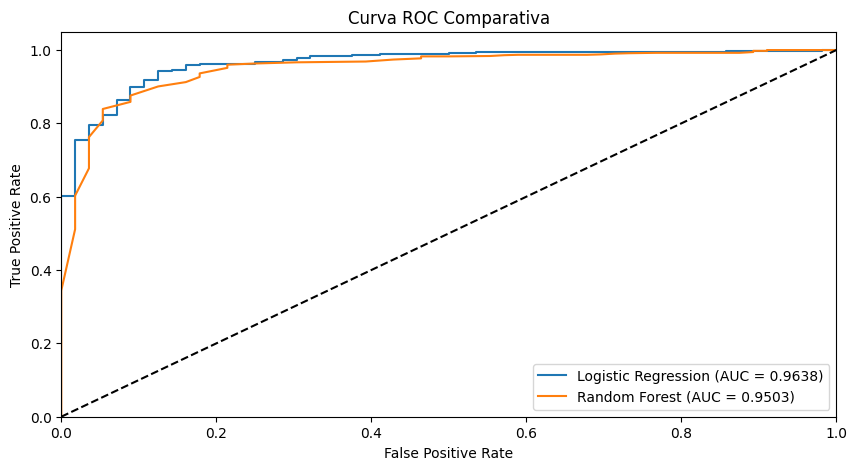

In [195]:
# train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import numpy as np

# Entrenar modelos
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100)
}

# Diccionario para almacenar los resultados
results = {}

for model_name, model in models.items():
    # Entrenar el modelo
    model.fit(X_train, y_train)
    # Predecir en el conjunto de prueba
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    # Evaluar el rendimiento
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    # Guardar los resultados
    results[model_name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "ROC AUC": roc_auc,
        "FPR": fpr,
        "TPR": tpr
    }

# Imprimir los resultados
for model_name, metrics in results.items():
    print(f"Resultados para {model_name}:")
    for metric, value in metrics.items():
        if isinstance(value, np.ndarray):
            continue
        print(f"{metric}: {value:.4f}")
    print("\n")

# Crear el gráfico comparativo de la curva ROC
plt.figure(figsize=(10, 5))
for model_name, metrics in results.items():
    plt.plot(metrics["FPR"], metrics["TPR"], label=f'{model_name} (AUC = {metrics["ROC AUC"]:.4f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC Comparativa')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Cross Validation (PRUEBA)
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer

# Definir las métricas de evaluación
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

# Validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluar cada modelo con validación cruzada
for model_name, model in models.items():
    print(f"Evaluando {model_name} con validación cruzada:")
    for metric_name, metric in scoring.items():
        scores = cross_val_score(model, X, y, cv=cv, scoring=metric)
        print(f"{metric_name}: {scores.mean():.4f} (+/- {scores.std():.4f})")
    print("\n")

Evaluando Logistic Regression con validación cruzada:
accuracy: 0.9385 (+/- 0.0010)
precision: 0.9395 (+/- 0.0013)
recall: 0.9985 (+/- 0.0009)
f1: 0.9681 (+/- 0.0005)
roc_auc: 0.9602 (+/- 0.0083)


Evaluando Random Forest con validación cruzada:
accuracy: 0.9355 (+/- 0.0010)
precision: 0.9361 (+/- 0.0010)
recall: 0.9993 (+/- 0.0009)
f1: 0.9664 (+/- 0.0004)
roc_auc: 0.9460 (+/- 0.0145)




In [ ]:
# CREAR NUEVO DATASET BINARIO CON THRESHOLD = 3 y aplicar los modelos implementados hasta ahora para ver si mejora
dfSimpleBinary_threshold3 = dfCleaned.copy()
dfSimpleBinary_threshold3['overall'] = dfSimpleBinary_threshold3['overall'].apply(lambda x: 1 if x > 3 else 0)
dfSimpleBinary_threshold3['overall'].value_counts()
dfSimpleBinary_threshold3.head(100)

,Unnamed: 0,overall,reviewText
0,0,1,issues
1,1,1,purchased device worked advertised never much ...
2,2,1,works expected sprung higher capacity think ma...
3,3,1,think worked greathad diff bran gb card went s...
4,4,1,bought retail packaging arrived legit orange e...
...,...,...,...
95,95,1,bought gb microsd card best buy needed one mic...
96,96,1,got couldnt pass deal incredibly fast htc sens...
97,97,1,get lot storage small price micro sd adapter c...
98,98,1,ultra micro sdhc fine got working neither pack...


In [201]:
dfSimpleBinary_threshold3.to_csv('amazon_reviews_simpleBinary_threshold3.csv', index=False)

In [ ]:
# Apply TF-IDF
tfidf = TfidfVectorizer(max_features=5000)  # Limit to 5000 features for simplicity
X_threshold3 = tfidf.fit_transform(dfSimpleBinary['reviewText'])  

# y = Etiqueta
y_threshold3 = dfSimpleBinary_threshold3['overall']  

In [203]:
X_train_threshold3, X_test_threshold3, y_train_threshold3, y_test_threshold3 = train_test_split(X_threshold3, y_threshold3, test_size=0.2, random_state=42)

Resultados para Logistic Regression:
Accuracy: 0.9288
Precision: 0.9294
Recall: 0.9978
F1 Score: 0.9624
ROC AUC: 0.9379


Resultados para Random Forest:
Accuracy: 0.9207
Precision: 0.9217
Recall: 0.9978
F1 Score: 0.9582
ROC AUC: 0.9199




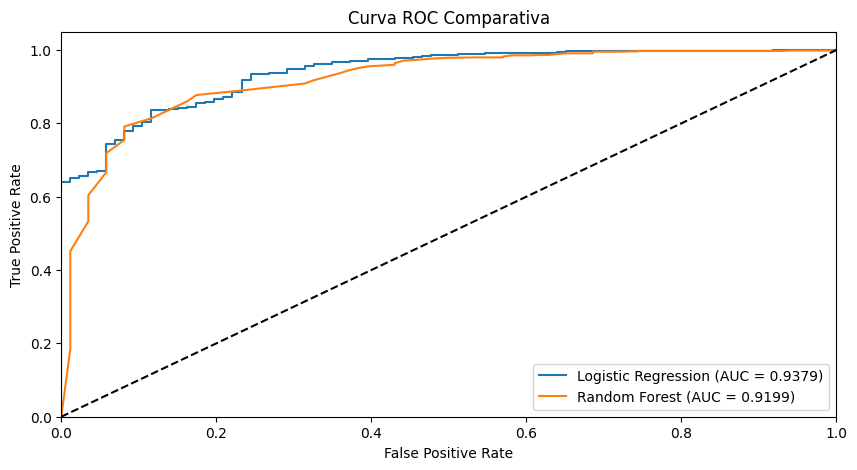

In [ ]:
# Entrenar modelos para threshold = 3
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100)
}

# Diccionario para almacenar los resultados
results = {}

for model_name, model in models.items():
    # Entrenar el modelo
    model.fit(X_train_threshold3, y_train_threshold3)
    # Predecir en el conjunto de prueba
    y_pred_threshold3 = model.predict(X_test_threshold3)
    y_pred_prob_threshold3 = model.predict_proba(X_test_threshold3)[:, 1]
    # Evaluar el rendimiento
    accuracy = accuracy_score(y_test_threshold3, y_pred_threshold3)
    precision = precision_score(y_test_threshold3, y_pred_threshold3)
    recall = recall_score(y_test_threshold3, y_pred_threshold3)
    f1 = f1_score(y_test_threshold3, y_pred_threshold3)
    fpr, tpr, _ = roc_curve(y_test_threshold3, y_pred_prob_threshold3)
    roc_auc = auc(fpr, tpr)
    # Guardar los resultados
    results[model_name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "ROC AUC": roc_auc,
        "FPR": fpr,
        "TPR": tpr
    }

# Imprimir los resultados
for model_name, metrics in results.items():
    print(f"Resultados para {model_name}:")
    for metric, value in metrics.items():
        if isinstance(value, np.ndarray):
            continue
        print(f"{metric}: {value:.4f}")
    print("\n")

# Crear el gráfico comparativo de la curva ROC
plt.figure(figsize=(10, 5))
for model_name, metrics in results.items():
    plt.plot(metrics["FPR"], metrics["TPR"], label=f'{model_name} (AUC = {metrics["ROC AUC"]:.4f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC Comparativa')
plt.legend(loc="lower right")
plt.show()